### Calculate evaluation scores collected from annotators


In [16]:
import os
import glob
import numpy as np
import itertools
import json
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_confusion_matrix(cm, x_classes, y_classes,
                          normalize=False,
                          title='Confusion matrix',
                          x_label = 'Given label',
                          y_label = 'True label',
                          cmap=plt.cm.Blues,
                          colorbar = 'vertical'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(orientation = colorbar)

    plt.xticks(np.arange(len(x_classes)), x_classes, rotation=45)
    plt.yticks(np.arange(len(y_classes)), y_classes)

    fmt = '.2f'
    thresh = (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh  + cm.min() else "black")

    plt.tight_layout()
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [3]:
def fleiss_kappa(ratings, n):
    '''
    Computes the Fleiss' kappa measure for assessing the reliability of 
    agreement between a fixed number n of raters when assigning categorical
    ratings to a number of items.
    
    Args:
        ratings: a list of (item, category)-ratings
        n: number of raters
    Returns:
        the Fleiss' kappa score
    
    See also:
        http://en.wikipedia.org/wiki/Fleiss'_kappa
    '''
    items = set()
    categories = set()
    n_ij = {}
    
    for i, c in ratings:
        items.add(i)
        categories.add(c)
        n_ij[(i,c)] = n_ij.get((i,c), 0) + 1
    
    N = len(items)
    
    p_j = {}
    for c in categories:
        p_j[c] = sum(n_ij.get((i,c), 0) for i in items) / (1.0*n*N)
    
    P_i = np.zeros(N, dtype = np.float32)
    for i in items:
        P_i[i] = (sum(n_ij.get((i,c), 0)**2 for c in categories)-n) / (n*(n-1.0))
    
    P_bar = np.sum(P_i) / N
    P_e_bar = sum(p_j[c]**2 for c in categories)
    
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    
    return P_i, kappa

#### Hard-code permutation

permutation is permutation from index in all_demos.json 

In [8]:
permutation = [121,  82,  91,  46,  21,   2,  94,  13,  78,  74,  64,  93,  76,
        49,  66, 113, 126, 132,   3, 100,  68,  20, 115,  99, 124, 102,
        83,  34, 109,  10,  25,  58,  96,  90, 144,  26,  32,  22,  24,
       131,  88,  97,  38,  31,  87, 134,  54,  17, 122,  40,  50,  61,
        42,  36, 123,  51,  56,  44,   4,   5,  15, 125, 106,  95, 143,
       147,  79, 139, 130,  60, 112, 116, 133,  35, 137,   8,  80,  84,
       105, 118,  62,  39,  85,  63, 117,  72,  14,  92,  71,  43, 140,
        67,  12,  69,  11, 110, 108, 145,  57, 114, 138, 127, 128,  65,
        52, 141,  81,  86,  53, 136,  75,  55,  47, 129, 120,  41,   0,
        73,   9, 104,  89,  28,   1,  16, 148,  29,  77, 149,  18, 111,
        59,  37, 101,  33, 119,  19,  23,  45, 107,   6,  30,  70, 142,
         7,  27, 135, 146,  98, 103,  48]

In [9]:
def oracle ( loop_index ):
    '''
    Return the correct label for a loop_index, which is a permutated from the true_index
    '''
    true_index = permutation[loop_index]
    
    t = true_index // 30
    
    return t

#### Reading annotators' judgment 

In [10]:
answer_code = ['Away', 'Closer', 'Past', 'Around', 'Next', 'None']
answer_map = dict((v, k) for k, v in enumerate(answer_code) )

# bitmap [evaluated_label][true_label] = total number of items of 'true_label' and evaluated as 'evaluated_label'
bitmap = np.zeros((6,5))

# ratings just a list of (item_index, evaluated_label)
ratings = []
raters = 0

path = os.path.join('..', '3D scenes', 'answers', 'answers_*.txt')

for file_name in glob.glob(path):
    with open(file_name, 'r') as fh:
        data = json.load(fh)
        raters += 1
        #print (data)
        
        for loop_index in range(150):
            true_y = oracle(loop_index) # from 0 to 4
            answer_y = answer_map[data[str(loop_index)]] # from 0 to 5
            
            bitmap[answer_y, true_y] += 1
            
            ratings.append( (loop_index, answer_y) )

Normalized confusion matrix
[[0.56666667 0.         0.23333333 0.         0.         0.2       ]
 [0.00666667 0.74666667 0.         0.00666667 0.21333333 0.02666667]
 [0.08       0.00666667 0.64666667 0.12       0.00666667 0.14      ]
 [0.         0.         0.08666667 0.73333333 0.00666667 0.17333333]
 [0.         0.41333333 0.06666667 0.02666667 0.35333333 0.14      ]]


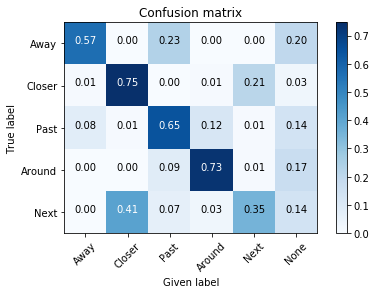

In [11]:
plot_confusion_matrix ( bitmap.T,
                       ['Away', 'Closer', 'Past', 'Around', 'Next', 'None'], 
                       ['Away', 'Closer', 'Past', 'Around', 'Next'], normalize = True)

In [12]:
P_i, kappa = fleiss_kappa(ratings, raters)

In [13]:
print (kappa)

0.5087378848426359


#### Some auxillary charts

##### Annotator (dis)agreement  for each test

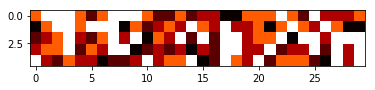

In [15]:
t = 1 - P_i
t.shape = (5,30)

plt.imshow(t, cmap='hot_r', interpolation='nearest')

##### Annotator (dis)agreement  for each action type

Away: 0.48333338
Closer: 0.72333336
Past: 0.65333337
Around: 0.6766666
Next: 0.44333333
Confusion matrix, without normalization
[[0.48333338 0.72333336 0.65333337 0.6766666  0.44333333]]


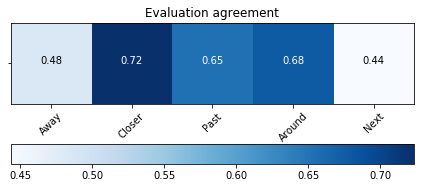

In [18]:
P_each_action = defaultdict (list)

for loop_index in range(150):
    P_each_action[oracle(loop_index)].append(P_i[loop_index])
    
for i in range(5):
    print (answer_code[i] + ': ' + str(np.average(P_each_action[i])))
    
q = np.array([np.average(P_each_action[i]) for i in range(5)])
q.shape = ( 1, 5 )

plot_confusion_matrix ( q,
       ['Away', 'Closer', 'Past', 'Around', 'Next'], 
       [''], normalize = False,
      x_label = '', y_label = '',
      colorbar = 'horizontal',
      title='Evaluation agreement')